Get started with required imports:

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import requests, os, time

from dotenv import load_dotenv

Load API key from .env and run a sanity check to confirm value is present.

In [2]:
API_KEY = os.getenv("NPS_API_KEY")

print(API_KEY is not None)

True


In [3]:
df = pd.ExcelFile(r"../data/NPS-Mortality-Data-CY2007-to-CY2024-Released-August-2024.xlsx")
df = df.parse(sheet_name="CY2007-Present Q2")
df.head()

Incident Date                             Park Name       Cause of Death  \
0    2007-01-01  Glen Canyon National Recreation Area         Undetermined   
1    2007-01-22  Golden Gate National Recreation Area             Drowning   
2    2007-01-22  Golden Gate National Recreation Area         Undetermined   
3    2007-01-29                 Natchez Trace Parkway  Motor Vehicle Crash   
4    2007-01-29                 Natchez Trace Parkway  Motor Vehicle Crash   

  Cause of Death Group \n(Used in the NPS Mortality Dashboard)   \
0                                       Undetermined              
1                                           Drowning              
2                                       Undetermined              
3                                Motor Vehicle Crash              
4                                Motor Vehicle Crash              

          Intent       Outcome     Sex     Age Range        Activity  
0   Undetermined  Fatal injury    Male           65+    Not Reported  
1  Unintentional  Fatal injury    Male  Not Reported  Vessel Related  
2   Undetermined  Fatal injury    Male  Not Reported  Vessel Related  
3  Unintentional  Fatal injury  Female         15-24        Driving   
4  Unintentional  Fatal injury  Female         45-54        Driving

Use .info() to get a look at the column names, datatypes, and counts.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635 entries, 0 to 4634
Data columns (total 9 columns):
 #   Column                                                        Non-Null Count  Dtype         
---  ------                                                        --------------  -----         
 0   Incident Date                                                 4635 non-null   datetime64[ns]
 1   Park Name                                                     4635 non-null   object        
 2   Cause of Death                                                4635 non-null   object        
 3   Cause of Death Group 
(Used in the NPS Mortality Dashboard)   4635 non-null   object        
 4   Intent                                                        4635 non-null   object        
 5   Outcome                                                       4635 non-null   object        
 6   Sex                                                           4635 non-null   object        
 7   Age Ran

Print a list of the columns that may be easier to reference.

In [5]:
print(df.columns)

Index(['Incident Date', 'Park Name', 'Cause of Death',
       'Cause of Death Group \n(Used in the NPS Mortality Dashboard) ',
       'Intent', 'Outcome', 'Sex', 'Age Range', 'Activity'],
      dtype='object')


I'm going to look more closely at the "Cause of death" and "Cause of Death Group \n..." columns to see if this data is redundant, or if I need to use both in my analysis.

Check if all values in all rows and columns are the same.

In [6]:
(df["Cause of Death"] == df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "]).all()

np.False_

Since the are not duplicates, I'm going to build a mask to count how many mismatches are in the data.

In [7]:
mask_mismatch = df["Cause of Death"] != df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "]
print("Total rows:", len(df))
print(mask_mismatch.sum())

Total rows: 4635
494


I'm going to look at some of the mismatches to see what the differences are.

In [8]:
df.loc[mask_mismatch, ["Cause of Death", "Cause of Death Group \n(Used in the NPS Mortality Dashboard) "]].head(20)

Cause of Death  \
8                      Avalanche   
9               Vessel Incident    
46              Vessel Incident    
48            Bicycle only crash   
56             Poisoning - Drugs   
65             Poisoning - Drugs   
76   Poisoning - Carbon monoxide   
90                   Hypothermia   
97                       Firearm   
112           Bicycle only crash   
118           Aircraft Incident    
119           Aircraft Incident    
120           Aircraft Incident    
121           Aircraft Incident    
131                  Hypothermia   
138                    Avalanche   
144                    Avalanche   
146    Horseback riding incident   
154                      Firearm   
155                      Firearm   

    Cause of Death Group \n(Used in the NPS Mortality Dashboard)   
8                                        Environmental             
9                                 Other Transportation             
46                                Other Transportation             
48                                Other Transportation             
56                                           Poisoning             
65                                           Poisoning             
76                                           Poisoning             
90                                       Environmental             
97                                               Other             
112                               Other Transportation             
118                               Other Transportation             
119                               Other Transportation             
120                               Other Transportation             
121                               Other Transportation             
131                                      Environmental             
138                                      Environmental             
144                                      Environmental             
146                               Other Transportation             
154                                              Other             
155                                              Other

It seems like I will be able to use the "Cause of Death" column and ignore the group column in my analysis. I'm going to look more closely at the cause of death column now.

In [9]:
df.groupby("Cause of Death").size()

Cause of Death
Aircraft Incident                          31
Aircraft incident                          46
Altitude                                    1
Asphyxiation                                7
Avalanche                                  41
Bicycle only crash                         23
Collapsing earth/sand                       2
Drowning                                  864
Electrocution                               4
Fall                                      505
Falling Ice                                 2
Falling tree/branch                        21
Fire/Burn                                   3
Fire/burn                                   2
Firearm                                     5
Flash flood                                14
Homicide                                   51
Horseback riding Incident                   1
Horseback riding incident                   3
Hyperthermia                               83
Hypothermia                                46
Legal Intervention 

There are some obvious duplicates in that list, so I'm going to normalize the causes to try to catch duplicates.

In [10]:
df["Cause of Death"] = df["Cause of Death"].str.strip().str.lower()

I want to see how many unique values I have now.

In [11]:
df["Cause of Death"].nunique()

42

I'm going to look at a list of the unique values just to see what I have since there aren't that many.

In [12]:
print(sorted(df["Cause of Death"].unique()))

['aircraft incident', 'altitude', 'asphyxiation', 'avalanche', 'bicycle only crash', 'collapsing earth/sand', 'drowning', 'electrocution', 'fall', 'falling ice', 'falling tree/branch', 'fire/burn', 'firearm', 'flash flood', 'homicide', 'horseback riding incident', 'hyperthermia', 'hypothermia', 'legal intervention', 'lightning strike', 'medical - during physical activity', 'medical - not during physical activity', 'medical - unknown', 'motor vehicle crash', 'other', 'poisoning - alcohol', 'poisoning - carbon monoxide', 'poisoning - drugs', 'poisoning - other', 'rockfall', 'skateboard incident', 'skiing incident', 'snowboard incident', 'snowmobile incident', 'struck by/against', 'suicide', 'train crash', 'trolly crash', 'undetermined', 'vessel incident', 'water diving incident', 'widlife incident']


Looking over the columns, I don't see any duplicates or names that should be changed right now. I'm going to change them back to have an uppercase character.

In [13]:
df["Cause of Death"] = df["Cause of Death"].str.title()
print(df["Cause of Death"])

0              Undetermined
1                  Drowning
2              Undetermined
3       Motor Vehicle Crash
4       Motor Vehicle Crash
               ...         
4630    Motor Vehicle Crash
4631    Motor Vehicle Crash
4632                Suicide
4633           Undetermined
4634           Undetermined
Name: Cause of Death, Length: 4635, dtype: object


Now that I know what column to use and I have eliminated case mismatches, I'm going to build a plot to just look at the causes of death.

I want to show the major causes of death. This will calculate the percentage of deaths attributed to each cause, and also group causes accounting for <5% of deaths be combined into an "other" category to avoid cluttering the plot. The variables defined here will be used in the plot.

In [14]:
cause_counts = df["Cause of Death"].value_counts(dropna=False)
percentages  = cause_counts / cause_counts.sum() * 100

major_causes = percentages[percentages >= 5].copy()
other_total  = percentages[percentages < 5].sum()
if other_total > 0:
    major_causes.loc["Other"] = other_total

I'm going to define my color palette to be used with this plot. I'm also going to set the colors up be the same for both medical cause deaths.

In [15]:
okabe_ito = [
    "#E69F00",
    "#56B4E9",
    "#009E73",
    "#F0E442",
    "#0072B2",
    "#D55E00",
    "#CC79A7", 
]
OTHER_GREY = "#9e9e9e"

def color_for_label(lbl):
    s = str(lbl).strip().lower()
    if s == "other":
        return OTHER_GREY

    if "medical" in s:
        return "#E69F00"  # orange
    return None



Now that the colors are defined, I'll build a for loop to cycle through the unused options.

In [16]:
used = {c for c in [color_for_label(x) for x in major_causes.index] if c}
remaining = [c for c in okabe_ito if c not in used]
colors = []
idx = 0
for lbl in major_causes.index:
    c = color_for_label(lbl)
    if c is None:
        c = remaining[idx % len(remaining)]
        idx += 1
    colors.append(c)

Now I'm going to create a pie chart that shows the major causes of death.

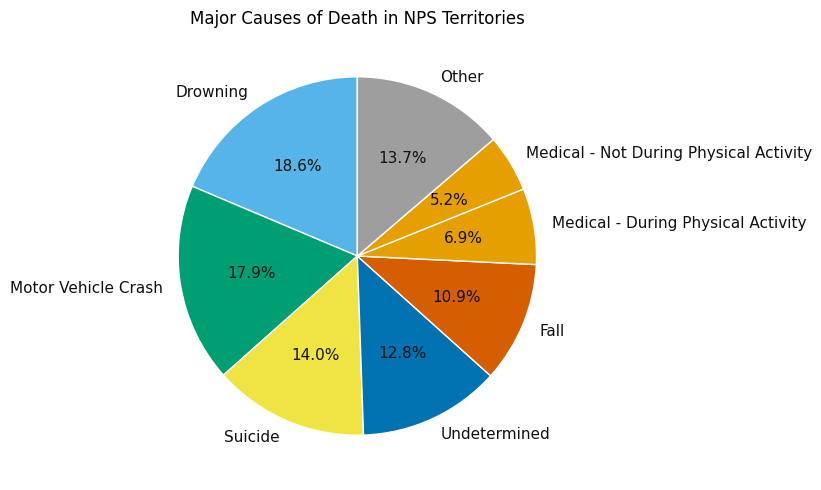

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    major_causes.values,
    labels=major_causes.index,
    colors=colors,
    autopct="%1.1f%%",
    wedgeprops={"linewidth": 1.0, "edgecolor": "white"},
    startangle=90
)
for t in texts:
    t.set_color("#111111")
    t.set_fontsize(11)

for t in autotexts:
    t.set_fontsize(11)
    t.set_color("#111111")
  

ax.set_title("Major Causes of Death in NPS Territories")

plt.tight_layout()
plt.show()


Drowning is the most frequent cause of death, so I'm going to look at that more closely to see if there are any common threads. I'm going to look at the number of drownings in each territory/park to see if there are any outliers. First, I'm going to normalize the park names to check for any case mismatches.

In [19]:
df["Park Name"].nunique()

203

In [20]:
df["Park Name"] = df["Park Name"].str.strip().str.lower()

In [22]:
df["Park Name"].nunique()

203

There was no change to the number of unique strings, so it doesn't seem like there are mismatches in this column. I'm going to change back to original caps formatting.

In [23]:
df["Park Name"] = df["Park Name"].str.title()
print(df["Park Name"])

0              Glen Canyon National Recreation Area
1              Golden Gate National Recreation Area
2              Golden Gate National Recreation Area
3                             Natchez Trace Parkway
4                             Natchez Trace Parkway
                           ...                     
4630          Valley Forge National Historical Park
4631    Delaware Water Gap National Recreation Area
4632                  Point Reyes National Seashore
4633                     Grand Canyon National Park
4634    Delaware Water Gap National Recreation Area
Name: Park Name, Length: 4635, dtype: object


I want to see if there are any null values in these columns.

In [25]:
df.isna().sum()

Incident Date                                                     0
Park Name                                                         0
Cause of Death                                                    0
Cause of Death Group \n(Used in the NPS Mortality Dashboard)      0
Intent                                                            0
Outcome                                                           0
Sex                                                               0
Age Range                                                        12
Activity                                                          0
dtype: int64

I know there are no missing values, so I'm going to quickly look at the drowning deaths per territory.

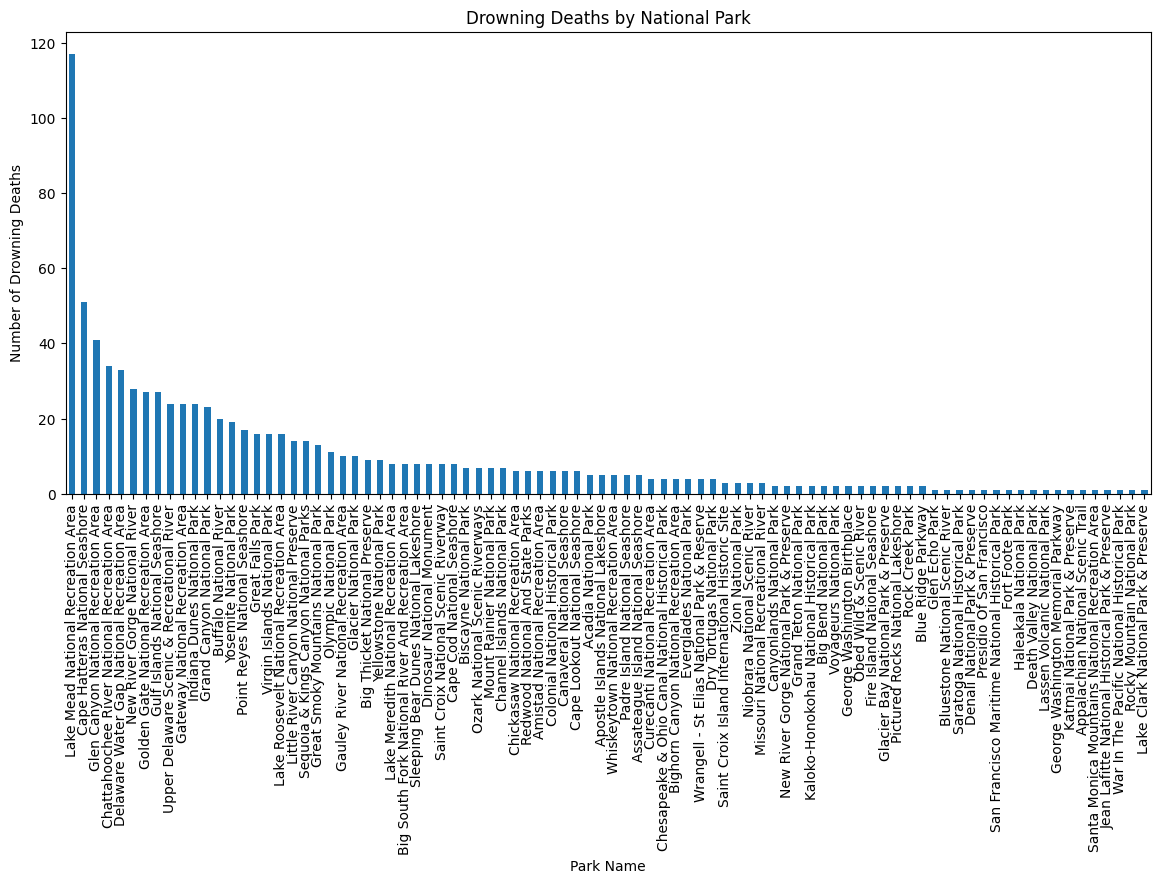

In [33]:
#Filter for drowning
drowning_df = df[df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "] == "Drowning"]

#Count drowning deaths in parks
drowning_counts = drowning_df["Park Name"].value_counts()

#Create bar graph with data
plt.figure(figsize=(14,6))
drowning_counts.plot(kind="bar")

plt.title("Drowning Deaths by National Park")
plt.xlabel("Park Name")
plt.ylabel("Number of Drowning Deaths")
plt.xticks(rotation=90)

plt.show()

It looks like there are some outliers, but you can't really see more than that since there are so many entries. I'm going to create another, neater plot with the top 25 parks.

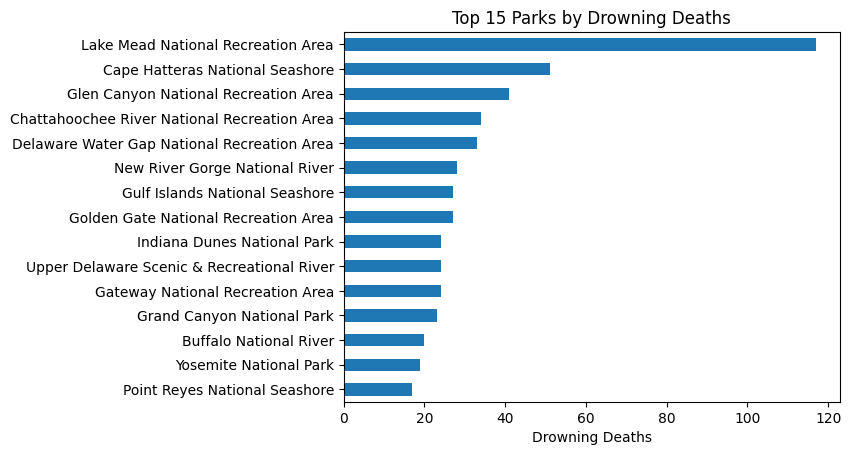

In [34]:
top_drowning = drowning_counts.head(15).sort_values()

top_drowning.plot(kind="barh")
plt.title("Top 15 Parks by Drowning Deaths")
plt.xlabel("Drowning Deaths")
plt.ylabel("")
plt.xticks(rotation=0)
plt.show()

I'm not working with the age range values right now, but I'm going to go ahead and look at those nulls since the rest of the dataset is complete.

In [26]:
print(df["Age Range"].unique())

['65+' 'Not Reported' '15-24' '45-54' '25-34' '55-64' '35-44' '0-14' nan
 '45 - 54' '35 - 44' 'Unintentional' '0 - 14']


So, there's problems. Unintentional, nan, and not reported should all be unknown values. 0 - 14 and 0-14 seem like duplicates. I need to fix the ranges and make as many as possible numeric values. I'm going to start by combining the unknown values and counting them.

In [27]:
unknown_age = {"Not Reported", "Unintentional", "Unknown", None, np.nan}

df["age_range_clean"] = df["Age Range"].replace(list(unknown_age), "Unknown")

print(df["age_range_clean"].value_counts())

age_range_clean
65+        827
55-64      676
Unknown    643
45-54      625
25-34      616
15-24      594
35-44      541
0-14       109
45 - 54      2
35 - 44      1
0 - 14       1
Name: count, dtype: int64


Now I'm going to normalize the spacing to combine the duplicate age ranges. I'm going to normalize the dashes

In [28]:
df["age_range_clean"] = (
    df["age_range_clean"]
    .str.replace(r"\s*-\s*", "-", regex=True)  # normalize dashes
    .str.strip()
)

I'm going to double check that the values combined correctly.

In [29]:
print(df["age_range_clean"].value_counts())

age_range_clean
65+        827
55-64      676
Unknown    643
45-54      627
25-34      616
15-24      594
35-44      542
0-14       110
Name: count, dtype: int64


I may have to revisit 65+, depending on what type of analysis I want to do, but for now I'm going to leave it as is and comvert the numeric ranges into min and max values, and calculate the midpoint. I'll use nan value for the max age in the 65+ column.

In [30]:
ranges = df["age_range_clean"].str.extract(r"(?P<min>\d+)-(?P<max>\d+)")
df["age_min"] = ranges["min"].astype(float)
df["age_max"] = ranges["max"].astype(float)

mask_plus = df["age_range_clean"].str.endswith("+", na=False)
df.loc[mask_plus, "age_min"] = df.loc[mask_plus, "age_range_clean"].str[:-1].astype(float)
df.loc[mask_plus, "age_max"] = np.nan 

df["age_mid"] = (df["age_min"] + df["age_max"]) / 2

Confirm that the columns have been added as numeric values

In [32]:
df.dtypes

Incident Date                                                    datetime64[ns]
Park Name                                                                object
Cause of Death                                                           object
Cause of Death Group \n(Used in the NPS Mortality Dashboard)             object
Intent                                                                   object
Outcome                                                                  object
Sex                                                                      object
Age Range                                                                object
Activity                                                                 object
age_range_clean                                                          object
age_min                                                                 float64
age_max                                                                 float64
age_mid                                 

In [31]:
print(df[["age_range_clean","age_min","age_max","age_mid"]].drop_duplicates())

   age_range_clean  age_min  age_max  age_mid
0              65+     65.0      NaN      NaN
1          Unknown      NaN      NaN      NaN
3            15-24     15.0     24.0     19.5
4            45-54     45.0     54.0     49.5
7            25-34     25.0     34.0     29.5
10           55-64     55.0     64.0     59.5
11           35-44     35.0     44.0     39.5
13            0-14      0.0     14.0      7.0


I know that I want to use data from other NPS datasets along with this information. I also know that there are 3 major sources (NPS Mortality Dataset, IRMA API, and NPS Data API) and the park name is inconsistent across all 3. The API datasets both use a 4 letter code that is  consistent. I'm going to use one of the APIs to match the names of the parks in the mortality dataset to the appropriate park code so that I may query either database for info with the 4 letter code.

In [35]:
BASE = "https://developer.nps.gov/api/v1/parks"
params = {"limit": 50, "start": 0, "api_key": API_KEY}
r = requests.get(BASE, params=params, timeout=30)
print(r.status_code) 

200


Requesting list of keys for data returned so I can see how to filter for the park code and the full name.

In [40]:
BASE = "https://developer.nps.gov/api/v1/parks"
params = {"limit": 50, "start": 0, "api_key": API_KEY}
r = requests.get(BASE, params=params, timeout=30)
data = r.json()["data"]
if data:
    print(list(data[0].keys()))

['id', 'url', 'fullName', 'parkCode', 'description', 'latitude', 'longitude', 'latLong', 'activities', 'topics', 'states', 'contacts', 'entranceFees', 'entrancePasses', 'fees', 'directionsInfo', 'directionsUrl', 'operatingHours', 'addresses', 'images', 'weatherInfo', 'name', 'designation', 'multimedia', 'relevanceScore']


I want the "fullName" and "parkCode" for each row. I'm going to craft an API call to build this dataframe.

In [39]:
def fetch_all_parks(api_key: str, page_size: int = 50, pause: float = 0.2) -> pd.DataFrame:
    base = "https://developer.nps.gov/api/v1/parks"
    start = 0
    rows = []

#Create a loop that will continue until there is no data or the data returned is < the page size
    while True:
        params = {"limit": page_size, "start": start, "api_key": api_key}
        resp = requests.get(base, params=params, timeout=30)
        resp.raise_for_status()
        #convert the response from JSON text to Python dictionary
        payload = resp.json()

        data = payload.get("data", [])
        if not data:
            break
        
        #The default parks response has more info than I need, so I'm going to filter just for the name and park code
        for item in data:
            rows.append({
                "fullName": item.get("fullName"),
                "parkCode": item.get("parkCode")
            })

        if len(data) < page_size:
            break

        start += page_size
        time.sleep(pause)

    return pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)

df_parks = fetch_all_parks(API_KEY, page_size=50)
df_parks.head()

fullName parkCode
0  Abraham Lincoln Birthplace National Historical...     abli
1                               Acadia National Park     acad
2                     Adams National Historical Park     adam
3                African American Civil War Memorial     afam
4            African Burial Ground National Monument     afbg

Saving the data with park names and park codes to a .csv file

In [41]:
print("Number of parks:", len(df_parks))
df_parks.to_csv("nps_parks_fullName_parkCode.csv", index=False)

Number of parks: 474


Now we'll examine the new dataframe.

In [42]:
df_parks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fullName  474 non-null    object
 1   parkCode  474 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB


In [43]:
df_parks.tail()

fullName parkCode
469  Yorktown Battlefield Part of Colonial National...     york
470                             Yosemite National Park     yose
471                      Yucca House National Monument     yuho
472           Yukon - Charley Rivers National Preserve     yuch
473                                 Zion National Park     zion

In [45]:
df_parks["fullName"].duplicated().sum()

np.int64(0)

In [46]:
df_parks["parkCode"].duplicated().sum()

np.int64(0)

Now that I have the names and the park codes, I'm going to build a dictionary with the df_parks dataframe that I can use to add the parkCode to our existing dataframe

In [47]:
code_map = dict(zip(df_parks["fullName"], df_parks["parkCode"]))

#Make a copy of the mortality dataframe so we aren't modifying original
df_with_codes = df.copy()

#Add columns for parkCode and Park Name
df_with_codes["parkCode"] = df_with_codes["Park Name"].map(code_map)

#Merge data from df_parks into new columns for exact matches
name_map = dict(zip(df_parks["fullName"], df_parks["fullName"]))
df_with_codes["fullName_official"] = df_with_codes["Park Name"].map(name_map)

#Print info about what was merged, what is missing
total = len(df_with_codes)
matched = df_with_codes["parkCode"].notna().sum()
print(f"Total rows: {total}")
print(f"Matched rows: {matched}")
print(f"Unmatched rows: {total - matched}")

unmatched_names = (
    df_with_codes.loc[df_with_codes["parkCode"].isna(), "Park Name"]
    .dropna()
    .drop_duplicates()
    .sort_values()
)

print("\nUnique unmatched park names:")
for nm in unmatched_names:
    print("-", nm)

Total rows: 4635
Matched rows: 4323
Unmatched rows: 312

Unique unmatched park names:
- Big South Fork National River And Recreation Area
- Canyon De Chelly National Monument
- Castillo De San Marcos National Monument
- George Washington Birthplace
- Haleakala National Park
- Hawaii Volcanoes National Park
- Jean Lafitte National Historical Park & Preserve
- Kaloko-Honokohau National Historical Park
- National Mall & Memorial Parks
- New River Gorge National River
- Not Reported
- President'S Park (White House)
- Presidio Of San Francisco
- Redwood National And State Parks
- Suitland
- Wilson'S Creek National Battlefield
- Wrangell - St Elias National Park & Reserve
- Yorktown Battlefield Part Of Colonial National Historical Park
